In [68]:
""" imports """
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import k_means
from scipy.stats import multivariate_normal as mvn

from collections import namedtuple

In [69]:
""" given ellipse function """

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    U, s, Vt = np.linalg.svd(covariance)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height = 2 * np.sqrt(s)

    # Draw the Ellipse
    for nsig in range(1, 5):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

In [70]:
""" load data """
flowers : list[str] = []

def assignFlower(raw : bytes) -> int:
    """ converts bytes data to a string, then assigns each flower type an int """
    global flowers
    flower : str = raw.decode("utf-8")
    flowers += [flower] if flower not in flowers else []
    return flowers.index(flower)

data = np.loadtxt(open("iris.data", "rb"), delimiter=",", converters={4 : assignFlower})
X = data[:,:4]
y = data[:,4]

k = len(flowers)
X.shape

(150, 4)

In [113]:
""" provides the top 2 PCs """

def svd(dataset : np.ndarray) -> np.ndarray:
    d = (dataset-dataset.mean(axis=0))  # /dataset.std()
    u, ls, vh = np.linalg.svd(d, full_matrices=True)

    s = np.zeros((u.shape[0],2))
    np.fill_diagonal(s, ls)

    dataset_svd1 = np.dot(u, s)
    dataset_svd = np.dot(d, vh[:2].T)
    return dataset_svd

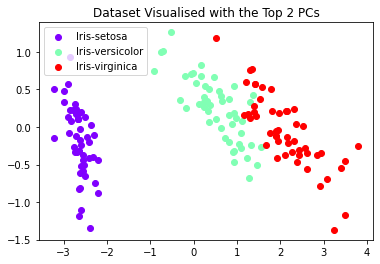

In [114]:
""" display data as 2D plot """
Z : np.ndarray = svd(X)

for i, colour in zip(range(k), cm.rainbow(np.linspace(0,1, k))):
    flowerIndexes = [int(j) for j, f in enumerate(y) if f==i]
    Zp = np.array([Z[j] for j in flowerIndexes]) 
    plt.scatter(Zp[:,0], Zp[:,1], color=colour, label=f"{flowers[i]}")

plt.title("Dataset Visualised with the Top 2 PCs")
plt.legend(loc="upper left")
plt.show()

In [115]:
Cluster = namedtuple("Cluster", "pi mu s")

class Theta:
    def __init__(self, X : np.ndarray, k : int):
        self.X = X
        self.k = k
        
        self.theta = []
        kMeans = k_means(Z, k)

        self.assignment = np.array(kMeans[1])

        self.theta.append([Cluster(1/3, mean, [[1,0],[0,1]]) for mean in kMeans[0]])
        # initiate theta with data from k_means
    
    def calc_r(self, i, c) -> float:
        theta = self.theta[-1]
        dist_c= mvn(mean=theta[c].mu,
                    cov= theta[c].s)
        t1 = dist_c.pdf(self.X[i])
        tPrior = theta[c].pi
        top = t1 * tPrior

        botSeries = []
        for c_p in (i for i in range(k)):
            dist_cp = mvn(mean=theta[c_p].mu,
                          cov= theta[c_p].s)
            b1 = dist_cp.pdf(self.X[i])
            bPrior = theta[c_p].pi
            botSeries.append(b1 * bPrior)
        
        bot = sum(botSeries)
        
        return top/bot
        

    def __next__(self):
        r = np.array([[self.calc_r(i, c) for c in range(self.k)] 
                      for i in range(len(self.X))])
        
        theta_n = []
        for c in range(self.k):
            rc = np.array([r_i[c] for r_i in r])
            sum_rc = sum(rc)
            pi = (1/len(r)) * sum_rc

            mu = (1/sum_rc) * sum((rc*self.X.T).T)

            s = np.matmul((rc*(self.X-mu).T), (self.X-mu))
            s = (1/sum_rc) * s

            theta_n += [Cluster(pi, mu, s)]
        self.theta += [theta_n]
        return theta_n

    def converge(self):
        converged : bool = len(self.theta) != 1
        while not converged:
            theta_o = self.theta[-1]
            theta_n = next(self)
            r = np.array([[self.calc_r(i, c) for c in range(self.k)] 
                      for i in range(len(self.X))])
            newAssignment = np.argmax(r, axis=1)
            converged = all(self.assignment == newAssignment)
            self.assignment = newAssignment
        
        return self.theta[-1]

theta = Theta(Z, k)

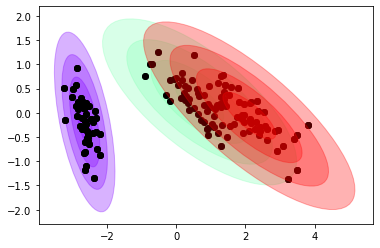

In [120]:
clusters = theta.converge()



for c, h in zip(clusters, cm.rainbow(np.linspace(0,1, k))):
    p = plt.scatter(Z[:,0], Z[:,1], color=(0,0,0))
    draw_ellipse(c.mu, c.s, alpha=0.3, color=h)